In [49]:
import tensorflow as tf
from PIL import Image
import numpy as np

IMG = 'lenna_full_res.jpg'

img = Image.open(IMG)
img = img.convert('RGB')
img = img.resize((192,192))
img = np.asarray(img)

interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], img[None, ...])
interpreter.invoke()
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([ -1, 192, 192,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.007843137718737125, 127),
  'quantization_parameters': {'scales': array([0.00784314], dtype=float32),
   'zero_points': array([127], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [50]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 267,
  'shape': array([   1, 3830,   10], dtype=int32),
  'shape_signature': array([  -1, 3830,   10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [51]:
output_data = interpreter.get_tensor(output_details[0]['index'])

out_data = output_data.flatten()

CONFIDENCE_THRESHOLD = 0.89
IOU_THRESHOLD = 0.2

preds = list()

for data_point in range(0, len(output_data.flatten()), 10):
    face_probability = out_data[data_point+1]
    x_min = out_data[data_point+6]
    y_min = out_data[data_point+7]
    x_max = out_data[data_point+8]
    y_max = out_data[data_point+9]

    if face_probability > CONFIDENCE_THRESHOLD:
        preds.append([face_probability, x_min, y_min, x_max, y_max])

preds = np.array(preds)

preds

array([[0.8997871 , 0.0671483 , 0.30888215, 0.38946012, 0.64462364],
       [0.8997871 , 0.05371863, 0.16115591, 0.3626008 , 0.7520609 ],
       [0.8997871 , 0.08057795, 0.24173385, 0.49689737, 0.6714829 ],
       [0.91321677, 0.05371863, 0.24173385, 0.3626008 , 0.83263886]],
      dtype=float32)

In [52]:
def calculate_iou(box1, box2):

    # Get box coordinates
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
  
    # Calculate intersection
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    # Calculate box areas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

calculate_iou([0, 0, 0.1, 0.1],[0.05, 0.05, 0.15, 0.15])

0.05 0.05 0.1 0.1


0.14285714285714288

In [53]:
def nms(preds):
	
    # List of boxes that exceed detection threshold
    accepted_boxes = list()

    # List of boxes after nms
    final_boxes = list()

    # Reject all boxes that don't exceed threshold
    for pred in preds: 
        prob = pred[0]
        if prob > CONFIDENCE_THRESHOLD:
            accepted_boxes.append(pred)
    
    # Sort in ascending order based on probability
    bboxes_sorted = sorted(accepted_boxes, reverse=False, key=lambda x: x[0])
    
    # Compare IoU between all boxes. Remove all boxes that don't exceed the threshold
    while len(bboxes_sorted) > 0:
        best_box = bboxes_sorted.pop()
        kept_boxes = 0
        for i in range(len(bboxes_sorted)-1, -1, -1):
            iou = calculate_iou(best_box[1:], bboxes_sorted[i][1:])
            if iou >= IOU_THRESHOLD:
                bboxes_sorted.pop(len(bboxes_sorted)-1-kept_boxes)
            else:
                kept_boxes+=1

        final_boxes.append(best_box)

    return final_boxes

0.080577955 0.24173385 0.3626008 0.6714829
0.053718634 0.24173385 0.3626008 0.7520609
0.0671483 0.30888215 0.3626008 0.64462364


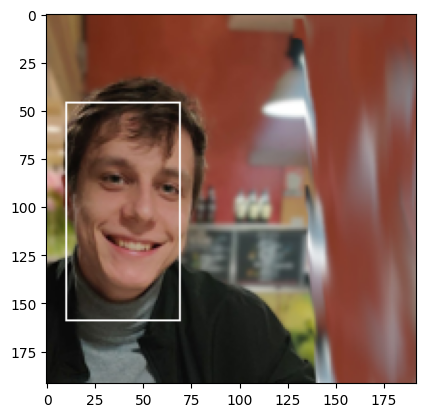

In [54]:

from PIL import ImageDraw
from matplotlib import pyplot as plt

img = Image.open(IMG)
img = img.convert('RGB')
img = img.resize((192,192))

img1=ImageDraw.Draw(img)

preds = nms(preds)

for pred in preds:
    p = pred[0]
    x1 = pred[1]
    y1 = pred[2]
    x2 = pred[3]
    y2 = pred[4]
    shape = ((192*x1,192*y1), (192*x2, 192*y2))
    img1.rectangle(shape)

    

plt.imshow(img)
